
## Clustering de artículos academicos sobre COVID19 

Proyecto minería de datos 

## (0) Instalacion e Importe de Librerias:

In [ ]:
pip install -U sentence-transformers

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
  Using cached sentence_transformers-2.2.2-py3-none-any.whl
  Using cached torchvision-0.16.0-cp310-cp310-manylinux1_x86_64.whl (6.9 MB)
  Using cached huggingface_hub-0.19.0-py3-none-any.whl (311 kB)
  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
  Using cached torch-2.1.0-cp310-cp310-manylinux1_x86_64.whl (670.2 MB)
  Using cached sentencepiece-0.1.99-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
  Using cached transformers-4.35.0-py3-none-any.whl (7.9 MB)
  Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)
  Using cached PyYAML-6.0.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (705 kB)
  Using cached fsspec-2023.10.0-py3-none-any.whl (166 kB)
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x

In [ ]:
pip install torch

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [ ]:
pip install nltk

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [ ]:
pip  install langdetect

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [ ]:
pip install sparknlp

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
  Using cached sparknlp-1.0.0-py3-none-any.whl (1.4 kB)
  Using cached spark_nlp-5.1.4-py2.py3-none-any.whl (540 kB)
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [ ]:
pip install gensim

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
  Using cached gensim-4.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.5 MB)
  Using cached smart_open-6.4.0-py3-none-any.whl (57 kB)
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [ ]:
pip install WordCloud

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
  Using cached wordcloud-1.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (455 kB)
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [ ]:
dbutils.library.restartPython()

In [ ]:
import pyspark
from pyspark.sql.functions import udf
from pyspark.ml.feature import Tokenizer, Normalizer, NGram, CountVectorizer, IDF
from pyspark.ml.clustering import KMeans, LDA
import nltk
import re
from pyspark.ml.linalg import Vectors, VectorUDT, SparseVector
from pyspark.sql.functions import udf, expr
import torch
from transformers import AutoModel, AutoTokenizer
import pandas as pd
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import ArrayType, StringType, FloatType, StructType, StructField, IntegerType, DoubleType, ByteType
from pyspark.ml.linalg import Vectors, DenseVector
from langdetect import detect
from sklearn.manifold import TSNE
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col, lit
from sentence_transformers import SentenceTransformer
from sparknlp.base import DocumentAssembler, Finisher
from sparknlp.annotator import SentenceEmbeddings
import torch.nn.functional as F
from pyspark.sql.functions import pandas_udf, count, col, collect_list
from pyspark.sql.functions import rand
from nltk.stem import WordNetLemmatizer
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator,TrainValidationSplit
from pyspark.ml import Pipeline
from wordcloud import WordCloud
import seaborn as sns
from pyspark.ml.clustering import LDA
from nltk.probability import FreqDist
from sklearn.metrics import silhouette_score
import random

In [ ]:
# Inicializar NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## (1) Lectura y Extraccion de datos:

In [ ]:
# File location and type
file_location = "/FileStore/tables/metadata.csv"
file_type = "csv"

# CSV options
infer_schema = "True"
first_row_is_header = "True"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(df)

cord_uid sha source_x title doi pmcid pubmed_id license abstract publish_time authors journal mag_id who_covidence_id arxiv_id pdf_json_files pmc_json_files url s2_id ug7v899j d1aafb70c066a2068b02786f8929fd9c900897fb PMC Clinical features of culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia 10.1186/1471-2334-1-6 PMC35282 11472636 no-cc OBJECTIVE: This retrospective chart review describes the epidemiology and clinical features of 40 patients with culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia. METHODS: Patients with positive M. pneumoniae cultures from respiratory specimens from January 1997 through December 1998 were identified through the Microbiology records. Charts of patients were reviewed. RESULTS: 40 patients were identified, 33 (82.5%) of whom required admission. Most infections (92.5%) were community-acquired. The infection affected all age groups but was most common in infants (32.5%) and pre-school children (22.5%). It occurred year-round but was most common in the fall (35%) and spring (30%). More than three-quarters of patients (77.5%) had comorbidities. Twenty-four isolates (60%) were associated with pneumonia, 14 (35%) with upper respiratory tract infections, and 2 (5%) with bronchiolitis. Cough (82.5%), fever (75%), and malaise (58.8%) were the most common symptoms, and crepitations (60%), and wheezes (40%) were the most common signs. Most patients with pneumonia had crepitations (79.2%) but only 25% had bronchial breathing. Immunocompromised patients were more likely than non-immunocompromised patients to present with pneumonia (8/9 versus 16/31, P = 0.05). Of the 24 patients with pneumonia, 14 (58.3%) had uneventful recovery, 4 (16.7%) recovered following some complications, 3 (12.5%) died because of M pneumoniae infection, and 3 (12.5%) died due to underlying comorbidities. The 3 patients who died of M pneumoniae pneumonia had other comorbidities. CONCLUSION: our results were similar to published data except for the finding that infections were more common in infants and preschool children and that the mortality rate of pneumonia in patients with comorbidities was high. 2001-07-04 Madani, Tariq A; Al-Ghamdi, Aisha A BMC Infect Dis null null null document_parses/pdf_json/d1aafb70c066a2068b02786f8929fd9c900897fb.json document_parses/pmc_json/PMC35282.xml.json https://www.ncbi.nlm.nih.gov/pmc/articles/PMC35282/ null 02tnwd4m 6b0567729c2143a66d737eb0a2f63f2dce2e5a7d PMC Nitric oxide: a pro-inflammatory mediator in lung disease? 10.1186/rr14 PMC59543 11667967 no-cc Inflammatory diseases of the respiratory tract are commonly associated with elevated production of nitric oxide (NO•) and increased indices of NO• -dependent oxidative stress. Although NO• is known to have anti-microbial, anti-inflammatory and anti-oxidant properties, various lines of evidence support the contribution of NO• to lung injury in several disease models. On the basis of biochemical evidence, it is often presumed that such NO• -dependent oxidations are due to the formation of the oxidant peroxynitrite, although alternative mechanisms involving the phagocyte-derived heme proteins myeloperoxidase and eosinophil peroxidase might be operative during conditions of inflammation. Because of the overwhelming literature on NO• generation and activities in the respiratory tract, it would be beyond the scope of this commentary to review this area comprehensively. Instead, it focuses on recent evidence and concepts of the presumed contribution of NO• to inflammatory diseases of the lung. 2000-08-15 Vliet, Albert van der; Eiserich, Jason P; Cross, Carroll E Respir Res null null null document_parses/pdf_json/6b0567729c2143a66d737eb0a2f63f2dce2e5a7d.json document_parses/pmc_json/PMC59543.xml.json https://www.ncbi.nlm.nih.gov/pmc/articles/PMC59543/ null ejv2xln0 06ced00a5fc04215949aa72528f2eeaae1d58927 PMC Surfactant protein-D and pulmonary 

In [ ]:
# Muestra los nombres de las columnas
print("Nombres de las columnas:")
for column in df.columns:
    print(column)


Nombres de las columnas:
cord_uid
sha
source_x
title
doi
pmcid
pubmed_id
license
abstract
publish_time
authors
journal
mag_id
who_covidence_id
arxiv_id
pdf_json_files
pmc_json_files
url
s2_id


## (2) Seleccion y limpieza del data set de interes:

In [ ]:
# Seleccionamos el abstract del conjunto de datos 
abstract = df.select('abstract')
data_rows = abstract.count()

# Imprime el número de datos 
print("Número de datos:", data_rows)

Número de datos: 1056660


In [ ]:
# Elimina filas con valores nulos y cuenta el número de filas restantes
data_no_null = abstract.na.drop()
num_non_null_rows = data_no_null.count()

# Imprime el número de datos no nulos
print("Número de datos no nulos:", num_non_null_rows)

Número de datos no nulos: 821458


In [ ]:
random.seed(42)

# Define el tamaño de la muestra que deseas
sample_size = 50000

# Realiza un muestreo aleatorio simple
data_sample = data_no_null.orderBy(rand(seed=1)).limit(sample_size)

# Muestra la cantidad de observaciones en la muestra
sampled_count = data_sample.count()
print(f"Número de observaciones en la muestra: {sampled_count}")


Número de observaciones en la muestra: 50000


In [ ]:
data_sample.show()

+--------------------+
|            abstract|
+--------------------+
|BACKGROUND: Befor...|
|Background: Bilat...|
|Recent research h...|
|SARS-CoV-2 virus ...|
|Novel coronavirus...|
|INTRODUCTION: In ...|
|BACKGROUND: The C...|
|Amid the ongoing ...|
|Analysing 92,598 ...|
|PURPOSE OF REVIEW...|
|The COVID-19 pand...|
|In many studies, ...|
|BACKGROUND The Or...|
|Nonwoven fiber ma...|
|At the inception ...|
|To manage the pub...|
|Bacterial CNS are...|
|PURPOSE: There ha...|
|BACKGROUND/AIM We...|
|The novel coronav...|
+--------------------+
only showing top 20 rows



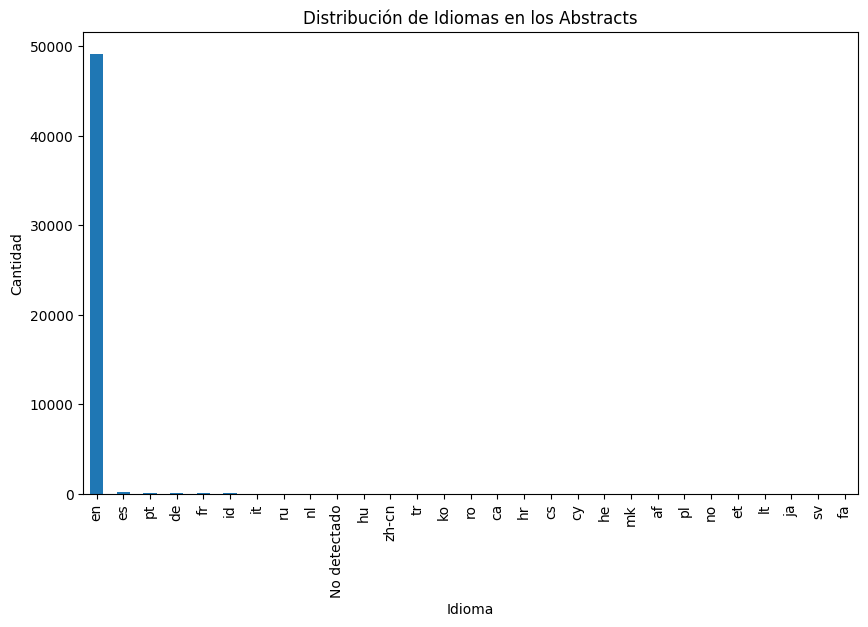

In [ ]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'No detectado'
    
# Ajustar el número de particiones antes del bucle y cachear el DataFrame
data_sample = data_sample.repartition(4).cache()

# Registra la función detect_language como una UDF
detect_language_udf = udf(detect_language, StringType())
    
data_detect = data_sample.withColumn("language", detect_language_udf(data_sample["abstract"]))

# Liberar la caché cuando ya no sea necesario
data_sample.unpersist()

result= data_detect.toPandas()

# Contar las ocurrencias de cada idioma
language_counts = result['language'].value_counts()

# Generar un gráfico de barras
plt.figure(figsize=(10, 6))
language_counts.plot(kind='bar')
plt.title("Distribución de Idiomas en los Abstracts")
plt.xlabel("Idioma")
plt.ylabel("Cantidad")
plt.show()

In [ ]:
# Ajustar el número de particiones antes del bucle y cachear el DataFrame
data_detect = data_detect.repartition(4).cache()

# Filtra los abstracts en inglés
data = data_detect.filter(data_detect.language == "en")

# Liberar la caché cuando ya no sea necesario
data_detect.unpersist()

# Muestra el número de observaciones en inglés
english_count = data.count()
print(f"Número de observaciones en inglés: {english_count}")

Número de observaciones en inglés: 49127


## (3) Preprocesamiento: 
(i) Conversion de texto a minusculas;

(ii) Eliminacion de caracteres no alfabeticos y stopwords;

In [ ]:
def preprocess_text(text):
    text_lower = text.lower()  # Convertir a minúsculas
    text_cleaned = re.sub(r'[^a-zA-Z\s]', '', text_lower)  # Eliminar caracteres no alfabéticos
    words = text_cleaned.split()
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]  # Eliminar stopwords
    cleaned_text = ' '.join(words)
    return cleaned_text

In [ ]:
# Crear la UDF para Spark
preprocess_udf = udf(preprocess_text, StringType())

# Aplicar la UDF al DataFrame
data_processed_text = data.withColumn("processed_abstract", preprocess_udf("abstract"))

## (4) Tokenizacion de Oraciones y Computo de Embeddings:

In [ ]:
# Función para dividir el texto en oraciones
def divide_en_oraciones(texto):
    oraciones = nltk.sent_tokenize(texto)
    return oraciones

In [ ]:
# Definir la UDF para tokenizar en oraciones
divide_en_oraciones_udf = udf(divide_en_oraciones, ArrayType(StringType()))

# Aplicar la UDF al DataFrame
data_text_sentences = data_processed_text.withColumn("processed_abstract_sentences", divide_en_oraciones_udf("processed_abstract"))

In [ ]:
def calculate_embeddings(text):
    model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

    # Realizar el proceso de tokenización y cálculo de embeddings
    tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt')

    with torch.no_grad():
        model_output = model(**encoded_input)

    token_embeddings = model_output.last_hidden_state
    attention_mask = encoded_input['attention_mask']
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    mean_pooled_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    normalized_embeddings = F.normalize(mean_pooled_embeddings, p=2, dim=1)

    # Convertir los embeddings normalizados a una lista de Python
    embeddings_list = normalized_embeddings.numpy().tolist()

    embeddings_spark = [Vectors.dense(embedding) for embedding in embeddings_list]

    return embeddings_spark

In [ ]:
# Convertir la función Python en una UDF con tipo de salida como ArrayType(DoubleType())
calculate_embeddings_udf = udf(calculate_embeddings, ArrayType(VectorUDT()))

# Aplicar la UDF al DataFrame con las oraciones
data_embeddings = data_text_sentences.withColumn("embeddings", calculate_embeddings_udf("processed_abstract_sentences"))

## (5) Preparacion de vectores numericos:

In [ ]:

def aggregate_vectors(vectors):
    # Calcula la media de los vectores para obtener un vector agregado
    aggregated_vector = [sum(col) / len(col) for col in zip(*vectors)]
    return Vectors.dense(aggregated_vector)

# Crea una UDF para aplicar la agregación a cada fila
aggregate_vectors_udf = udf(aggregate_vectors, VectorUDT())

# Aplica la UDF al DataFrame
data_aggregate = data_embeddings.withColumn("aggregated_features", aggregate_vectors_udf("embeddings"))

In [ ]:
data_cluster = data_aggregate.withColumnRenamed("aggregated_features", "features")
# Seleccionar la columna transformada 'embeddings_transformed'
cluster_data = data_cluster.select("features")

## (6) Clusterizacion:

In [ ]:
# Ajustar el número de particiones antes del bucle y cachear el DataFrame
cluster_data = cluster_data.repartition(4).cache()

# Entrenar el modelo KMeans y evaluar la inercia
min_clusters = 2 
max_clusters = 20

inertia_scores = []

# Mover la creación del evaluador fuera del bucle
evaluator = ClusteringEvaluator()

for k in range(min_clusters, max_clusters + 1):
    # Ajustar el modelo KMeans
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(cluster_data)

    # Transformar los datos y evaluar la métrica del codo
    clustered_data = model.transform(cluster_data)
    inertia_scores.append(model.summary.trainingCost)

# Liberar la caché cuando ya no sea necesario
cluster_data.unpersist()


DataFrame[features: vector]

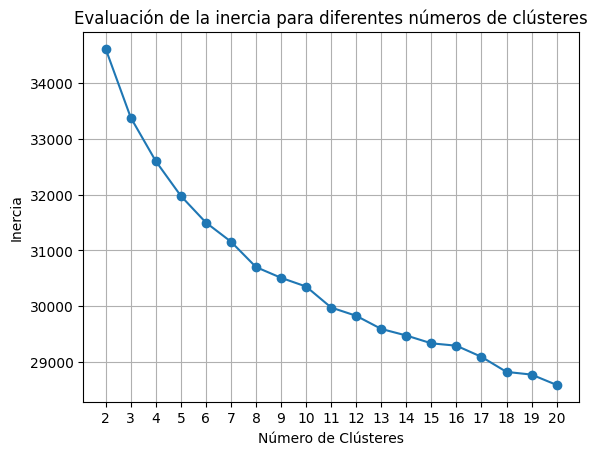

In [ ]:
# Generar la gráfica de inercia vs. número de clústeres
num_clusters = range(min_clusters, max_clusters + 1)
plt.plot(num_clusters, inertia_scores, marker='o')
plt.xlabel('Número de Clústeres')
plt.ylabel('Inercia')
plt.title('Evaluación de la inercia para diferentes números de clústeres')
plt.xticks(range(min_clusters, max_clusters + 1))
plt.grid(True)
plt.show()

In [ ]:
# Ajustar el número de particiones antes del bucle y cachear el DataFrame
data_cluster = data_cluster.repartition(4).cache()

# Entrenar el modelo de K-Means
kmeans = KMeans().setK(10).setSeed(1)
model = kmeans.fit(data_cluster)

# Asignar cada texto a un clúster
clustered_data = model.transform(data_cluster)

# Calcular la Inercia
inertia = model.summary.trainingCost
print(f"Inercia: {inertia}")

# Liberar la caché cuando ya no sea necesario
data_cluster.unpersist()

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
File <command-3490103031162765>, line 2
      1 # Ajustar el número de particiones antes del bucle y cachear el DataFrame
----> 2 data_cluster = data_cluster.repartition(4).cache()
      4 # Entrenar el modelo de K-Means
      5 kmeans = KMeans().setK(10).setSeed(1)

File /databricks/spark/python/pyspark/instrumentation_utils.py:47, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     45 start = time.perf_counter()
     46 try:
---> 47     res = func(*args, **kwargs)
     48     logger.log_success(
     49         module_name, class_name, function_name, time.perf_counter() - start, signature
     50     )
     51     return res

File /databricks/spark/python/pyspark/sql/dataframe.py:1641, in DataFrame.cache(self)
   1613 """Persists the :class:`DataFrame` with the default storage level (`MEMORY_AND_DISK`).
   1614 
   1615 .. versio

In [ ]:
# Ajustar el número de particiones antes del bucle y cachear el DataFrame
data_cluster = data_cluster.repartition(4).cache()

# Calcular el Silhouette Score
evaluator = ClusteringEvaluator()
silhouette_score = evaluator.evaluate(clustered_data)
print(f"Silhouette Score: {silhouette_score}")

# Liberar la caché cuando ya no sea necesario
data_cluster.unpersist()

In [ ]:
features = np.array(clustered_data.select("features").collect())
predictions = np.array(clustered_data.select("prediction").collect())

# Aplanar los datos de features
features_flat = np.array([f[0] for f in features])

# Reduce los vectores a 2 dimensiones utilizando T-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
vectors_2d = tsne.fit_transform(features_flat)

# Graficar los resultados de T-SNE coloreados por las predicciones de K-Means
plt.figure(figsize=(8, 8))
scatter = plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c=predictions, cmap='viridis', label='Clusters')

# Agregar etiquetas para cada punto
for i, txt in enumerate(predictions):
    plt.annotate(txt[0], (vectors_2d[i, 0], vectors_2d[i, 1]), textcoords="offset points", xytext=(0, 5), ha='center')

# Agregar leyenda
plt.legend()

plt.title('Visualización T-SNE de los resultados de K-Means')
plt.show()

In [ ]:
# Calcular el número de documentos por clúster
cluster_counts = clustered_data.groupBy("prediction").agg(count("*").alias("count")).orderBy("prediction")

# Mostrar el número de documentos por clúster
cluster_counts.show()

# Convertir los datos a Pandas para graficar
cluster_counts_pd = cluster_counts.toPandas()

# Graficar el número de documentos por clúster
plt.figure(figsize=(10, 6))
plt.bar(cluster_counts_pd["prediction"], cluster_counts_pd["count"], color='blue')
plt.xlabel('Clúster')
plt.ylabel('Número de Documentos')
plt.title('Número de Documentos por Clúster')
plt.show()

In [ ]:
# Contar el número de documentos en cada clúster
cluster_counts = clustered_data.groupBy("prediction").count()

# Calcular el porcentaje de documentos en cada clúster
total_documents = clustered_data.count()
cluster_counts = cluster_counts.withColumn("percentage", (col("count") / total_documents) * 100)

# Mostrar los resultados
cluster_counts.show()

# Convertir el DataFrame de PySpark a un DataFrame de pandas para facilitar la visualización
cluster_counts_pd = cluster_counts.toPandas()

# Graficar la distribución de documentos por clúster
plt.figure(figsize=(10, 6))
plt.bar(cluster_counts_pd["prediction"], cluster_counts_pd["count"], color='skyblue')
plt.xlabel('Clúster')
plt.ylabel('Número de Documentos')
plt.title('Distribución de Documentos por Clúster')
plt.show()

In [ ]:
# 4. Agrupar los documentos por clúster
grouped_data = clustered_data.groupBy("prediction").agg(collect_list("processed_abstract").alias("documents"))

# 5. Procesar y analizar los documentos en cada clúster
for row in grouped_data.collect():
    cluster_id = row["prediction"]
    documents = row["documents"]

    # Realizar un análisis de frecuencia de palabras (puedes personalizar esto según tus necesidades)
    words = ' '.join(documents).split()
    fdist = FreqDist(words)

    # Imprimir las palabras más significativas para cada clúster
    print(f"Cluster {cluster_id}: {fdist.most_common(10)}")

## (7) Distribucion de Topicos: Aplicacion de Latent Dirichlet Allocation (LDA)

In [ ]:
# Función para tokenizar un texto
def tokenizer(text):
    # Aquí debes implementar tu lógica de tokenización
    # Puedes usar la función preprocess_text que definiste anteriormente
    return text.split()  # Esto es un ejemplo simple, puedes ajustarlo según tus necesidades

# UDF para tokenizar
tokenizer_udf = udf(tokenizer, ArrayType(StringType()))

# Aplicar la tokenización al DataFrame
clustered_data_tokenized = clustered_data.withColumn("tokens", tokenizer_udf("processed_abstract"))

# Crear un objeto CountVectorizer para contar las palabras
cv = CountVectorizer(inputCol="tokens", outputCol="raw_features", vocabSize=5000, minDF=10.0)
cv_model = cv.fit(clustered_data_tokenized)
result_cv = cv_model.transform(clustered_data_tokenized)

# Calcular IDF
idf = IDF(inputCol="raw_features", outputCol="tfidf_features")
idf_model = idf.fit(result_cv)
result_tfidf = idf_model.transform(result_cv)

# Número de palabras representativas por clúster
num_top_words = 10
num_clusters = 15 

# Función para obtener las palabras más representativas por clúster
def get_top_words_by_cluster(cluster_df, num_clusters, num_words=10):
    top_words_by_cluster = {}
    for cluster in range(num_clusters):
        # Filtrar por clúster
        cluster_data = cluster_df.filter(cluster_df['prediction'] == cluster)
        
        # Obtener las palabras más representativas usando TF-IDF
        top_words = idf_model.idf.toArray().argsort()[:num_words]
        top_words = [cv_model.vocabulary[i] for i in top_words]
        
        top_words_by_cluster[cluster] = top_words
        
    return top_words_by_cluster

# Obtener las palabras más representativas por clúster
top_words_by_cluster = get_top_words_by_cluster(result_tfidf, num_clusters, num_top_words)

# Generar la nube de palabras para cada clúster
for cluster, top_words in top_words_by_cluster.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(top_words))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Cluster {cluster} - Palabras Representativas')
    plt.axis('off')
    plt.show()

Latent Dirichlet Allocation (LDA)

In [ ]:
# Definir la función de preprocesamiento
def preprocess_text(text):
    text_lower = text.lower()
    text_cleaned = re.sub(r'[^a-zA-Z\s]', '', text_lower)
    words = text_cleaned.split()
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Eliminar palabras con longitud menor a 3
    words = [word for word in words if word not in stop_words and len(word) >= 3]

    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    cleaned_text = ' '.join(lemmatized_words)
    return cleaned_text

# Convertir la función de Python en una función UDF de PySpark
preprocess_udf = udf(preprocess_text, StringType())

# Aplicar la función UDF al DataFrame en la columna 'abstract'
data_lda = data.withColumn("abstract_processed", preprocess_udf(data["abstract"]))

In [ ]:
# Tokenizar el texto preprocesado
tokenizer = Tokenizer(inputCol="abstract_processed", outputCol="tokens")
data_tokenized = tokenizer.transform(data_lda)

In [ ]:
# Ajustar el número de particiones antes del bucle y cachear el DataFrame
data_tokenized = data_tokenized.repartition(4).cache()

# Definir el pipeline con el CountVectorizer, IDF y LDA
cv = CountVectorizer(inputCol="tokens", outputCol="raw_features")
idf = IDF(inputCol="raw_features", outputCol="features")
lda = LDA(featuresCol="features", seed=123)  

pipeline = Pipeline(stages=[cv, idf, lda])

# Crear todas las combinaciones posibles de parámetros
paramGrid = (ParamGridBuilder()
             .addGrid(cv.vocabSize, [1000, 5000, 10000])
             .addGrid(cv.minDF, [5.0, 10.0])
             .addGrid(lda.maxIter, [50, 100])
             .addGrid(lda.k, [10, 15, 20])
             .build())

best_perplexity = float("inf")
best_log_likelihood = float("-inf")
best_model_perplexity = None
best_model_log_likelihood = None

# Crear un diccionario para almacenar los resultados de cada combinación de parámetros
results = {}

best_perplexity = float("inf")
best_log_likelihood = float("-inf")
best_model_perplexity = None
best_model_log_likelihood = None
best_params_perplexity = None
best_params_log_likelihood = None

for params in paramGrid:
    # Configurar los hiperparámetros en el pipeline
    cv_vocabSize = params[cv.vocabSize]
    cv_minDF = params[cv.minDF]
    lda_maxIter = params[lda.maxIter]
    lda_k = params[lda.k]

    cv.setParams(vocabSize=cv_vocabSize, minDF=cv_minDF)
    lda.setParams(maxIter=lda_maxIter, k=lda_k)

    # Crear un nuevo pipeline con los parámetros configurados
    pipeline = Pipeline(stages=[cv, idf, lda])

    # Ajustar el modelo al conjunto de datos
    model = pipeline.fit(data_tokenized)

    # Calcular métricas de evaluación: perplexity y log-likelihood
    transformed_data = model.transform(data_tokenized)
    log_likelihood = model.stages[-1].logLikelihood(transformed_data)
    perplexity = model.stages[-1].logPerplexity(transformed_data)

    # Almacenar los resultados de esta combinación de parámetros en el diccionario
    results[(cv_vocabSize, cv_minDF, lda_maxIter, lda_k)] = {
        "perplexity": perplexity,
        "log_likelihood": log_likelihood
    }

    # Actualizar el mejor modelo según la métrica de perplexity
    if perplexity < best_perplexity:
        best_perplexity = perplexity
        best_model_perplexity = model
        best_params_perplexity = (cv_vocabSize, cv_minDF, lda_maxIter, lda_k)

    # Actualizar el mejor modelo según la métrica de log-likelihood
    if log_likelihood > best_log_likelihood:
        best_log_likelihood = log_likelihood
        best_model_log_likelihood = model
        best_params_log_likelihood = (cv_vocabSize, cv_minDF, lda_maxIter, lda_k)

# Liberar la caché cuando ya no sea necesario
data_tokenized.unpersist()

# Mostrar los resultados de todas las combinaciones de parámetros
print("Resultados de todas las combinaciones de parámetros:")
for params, metrics in results.items():
    print(f"Parámetros: {params}, Perplexity: {metrics['perplexity']}, Log Likelihood: {metrics['log_likelihood']}")

Resultados de todas las combinaciones de parámetros:
Parámetros: (1000, 5.0, 50, 10), Perplexity: 6.390346026027019, Log Likelihood: -61604312.39634758
Parámetros: (1000, 5.0, 50, 15), Perplexity: 6.32060065707067, Log Likelihood: -60931952.01400116
Parámetros: (1000, 5.0, 50, 20), Perplexity: 6.276259533847227, Log Likelihood: -60504494.03348862
Parámetros: (1000, 5.0, 100, 10), Perplexity: 6.367183978607173, Log Likelihood: -61381025.26930004
Parámetros: (1000, 5.0, 100, 15), Perplexity: 6.299258214682356, Log Likelihood: -60726206.271464564
Parámetros: (1000, 5.0, 100, 20), Perplexity: 6.254349457892867, Log Likelihood: -60293276.18108707
Parámetros: (1000, 10.0, 50, 10), Perplexity: 6.387035173501044, Log Likelihood: -61572395.06472303
Parámetros: (1000, 10.0, 50, 15), Perplexity: 6.3189986015344255, Log Likelihood: -60916507.85349262
Parámetros: (1000, 10.0, 50, 20), Perplexity: 6.279717328815518, Log Likelihood: -60537827.92191367
Parámetros: (1000, 10.0, 100, 10), Perplexity: 6.

In [ ]:
# Mostrar los mejores modelos y sus métricas
print("Mejor modelo según perplexity:")
print(f"Parámetros: {best_params_perplexity}")
print(f"Perplexity: {best_perplexity}")

print("Mejor modelo según log-likelihood:")
print(f"Parámetros: {best_params_log_likelihood}")
print(f"Log Likelihood: {best_log_likelihood}")

Mejor modelo según perplexity:
Parámetros: (1000, 5.0, 100, 20)
Perplexity: 6.254349457892867
Mejor modelo según log-likelihood:
Parámetros: (1000, 5.0, 100, 20)
Log Likelihood: -60293276.18108707


In [ ]:
data_tokenized = data_tokenized.repartition(4).cache()

# Crear la bolsa de palabras (CountVectorizer)
cv = CountVectorizer(inputCol="tokens", outputCol="raw_features", vocabSize=1000, minDF=5.0)
model = cv.fit(data_tokenized)
result_cv = model.transform(data_tokenized)

data_tokenized.unpersist()

# Obtener el vocabulario del modelo CountVectorizer
vocab = model.vocabulary

# FDI
idf = IDF(inputCol="raw_features", outputCol="features") 
idfModel = idf.fit(result_cv) 
result_tfidf = idfModel.transform(result_cv)

In [ ]:
# Construir el modelo LDA
num_topics = 10  # Número de tópicos
max_iterations = 100  # Número máximo de iteraciones
lda = LDA(k=num_topics, maxIter=max_iterations, seed=123, optimizer="online")
lda_model = lda.fit(result_tfidf)

ll = lda_model.logLikelihood(result_tfidf)
lp = lda_model.logPerplexity(result_tfidf)

print("The lower bound on the log likelihood of the entire corpus: " + str(ll))
print("The upper bound on perplexity: " + str(lp))

The lower bound on the log likelihood of the entire corpus: -61405725.04359867
The upper bound on perplexity: 6.368968318510401


In [ ]:
# Transformar documentos utilizando el modelo LDA
transformed = lda_model.transform(result_tfidf)
transformed.select('topicDistribution').show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topicDistribution                                                                                                                                                                                                    |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.002482251417502769,0.002396032897510043,0.0026087415823317335,0.0020568188775409767,0.002448355726652476,0.0021962158390615174,0.31682739804193966,0.001911534228666724,0.0025103794169889586,0.6645622719718052] |
|[0.21170716398736747,0.10916694558854213,2.446315975561154E-4,1.9287230865864478E-4,0.0635029463015058,2.0594372511856948E-4,2.49924822

In [ ]:
# Obtener la distribución de tópicos para cada documento
topic_distribution_array = np.array(transformed.select("topicDistribution").collect())

# Crear un DataFrame para visualizar los resultados detallados
detailed_result_df = pd.DataFrame(topic_distribution_array[:, 0, :], columns=[f'Tópico_{i+1}' for i in range(num_topics)])
detailed_result_df.insert(0, 'Documento', range(1, len(detailed_result_df) + 1))

# Mostrar el DataFrame con la distribución de tópicos para cada documento
print(detailed_result_df)


       Documento  Tópico_1  Tópico_2  ...  Tópico_8  Tópico_9  Tópico_10
0              1  0.000780  0.000753  ...  0.000601  0.124913   0.034045
1              2  0.000248  0.277139  ...  0.000191  0.000251   0.000216
2              3  0.001522  0.462868  ...  0.001172  0.054294   0.001325
3              4  0.573237  0.000378  ...  0.000302  0.082610   0.000341
4              5  0.059522  0.172097  ...  0.000282  0.000371   0.050336
...          ...       ...       ...  ...       ...       ...        ...
49122      49123  0.000808  0.290974  ...  0.000622  0.437867   0.000703
49123      49124  0.000279  0.157745  ...  0.060326  0.000282   0.000243
49124      49125  0.074140  0.570516  ...  0.000778  0.001022   0.085456
49125      49126  0.050329  0.000345  ...  0.455139  0.000361   0.492103
49126      49127  0.000418  0.000403  ...  0.000322  0.730183   0.000363

[49127 rows x 11 columns]


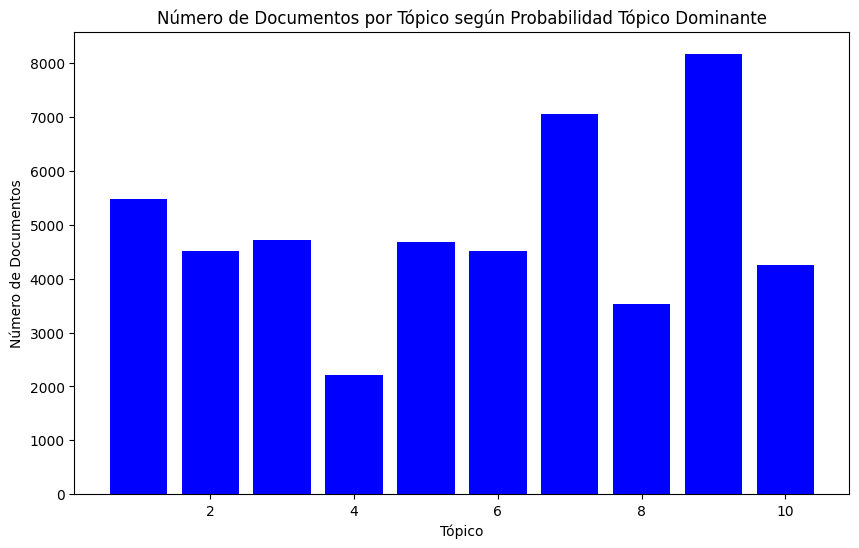

In [ ]:
# Obtener la distribución de tópicos para cada documento
topic_distribution_array = np.array(transformed.select("topicDistribution").collect())

# Extraer la probabilidad máxima de cada fila (considerando la estructura actual)
dominant_topic_probabilities = topic_distribution_array[:, 0, :].max(axis=1)

# Encontrar el índice del tópico con la probabilidad más alta para cada documento
dominant_topic_indices = np.argmax(topic_distribution_array[:, 0, :], axis=1)

# Crear un DataFrame para visualizar los resultados
result_df = pd.DataFrame({
    'Documento': range(1, len(dominant_topic_indices) + 1),
    'Tópico Dominante': dominant_topic_indices + 1,  # Sumar 1 para tener índices basados en 1
    'Probabilidad Tópico Dominante': dominant_topic_probabilities
})

# Contar el número de documentos por tópico
document_count_by_topic = result_df['Tópico Dominante'].value_counts().sort_index()

# Crear un gráfico de barras para visualizar los resultados
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(document_count_by_topic.index, document_count_by_topic.values, color='blue')
ax.set_xlabel('Tópico')
ax.set_ylabel('Número de Documentos')
ax.set_title('Número de Documentos por Tópico según Probabilidad Tópico Dominante')

plt.show()

In [ ]:
# Obtener el vocabulario del CountVectorizer
vocabulary = model.vocabulary
vocabulary_dict = {i: term for i, term in enumerate(vocabulary)}

# Crear una función definida por el usuario (UDF) para mapear los índices de palabras a palabras reales
@udf(returnType=ArrayType(StringType()))
def map_indices_to_words(words):
    return [vocabulary_dict[int(index)] for index in words]

# Aplicar el UDF a las columnas de términos e índices de peso de tu modelo LDA
result_with_words = lda_model.describeTopics(maxTermsPerTopic=10).withColumn('words', map_indices_to_words('termIndices'))

# Recolectar los datos en el entorno local
topics_data = result_with_words.select('topic', 'words', 'termWeights').collect()

# Crear un diccionario para almacenar las palabras clave por tópico
keywords_by_topic = {}

# Iterar sobre los datos de tópicos
for row in topics_data:
    topic = row['topic']
    words = row['words']
    term_weights = row['termWeights']

    # Agregar las palabras ponderadas
    keywords_by_topic[topic] = list(zip(words, term_weights))

# Imprimir las palabras clave por tópico
for topic, keywords in keywords_by_topic.items():
    print(f"Tópico {topic + 1}: {keywords}")

Tópico 1: [('patient', 0.018732211081541578), ('treatment', 0.01515365423802164), ('trial', 0.01256434219816724), ('clinical', 0.011286865500711821), ('therapy', 0.01102987105853101), ('lung', 0.010508807218827791), ('disease', 0.00940935141135673), ('diabetes', 0.008144897647766632), ('review', 0.007787240592844369), ('pulmonary', 0.007683477568043876)]
Tópico 2: [('care', 0.02343116556350775), ('health', 0.01630637222747265), ('healthcare', 0.015276285810770639), ('service', 0.015228172503982331), ('vaccine', 0.013942346877789499), ('worker', 0.0092340122715009), ('patient', 0.009146985696964555), ('hospital', 0.008948854337180586), ('staff', 0.008733511522087864), ('emergency', 0.008724773518913194)]
Tópico 3: [('application', 0.010265398587132712), ('model', 0.009928187593101719), ('system', 0.008592358118702823), ('device', 0.008333149862042305), ('air', 0.008134684876294816), ('network', 0.007715990628330807), ('approach', 0.007198758544800114), ('process', 0.007189548160743274),

In [ ]:
# Obtener la distribución de tópicos para cada documento
topic_distribution_array = np.array(transformed.select("topicDistribution").collect())

# Crear un DataFrame con la distribución de tópicos para cada documento
result_df = pd.DataFrame(topic_distribution_array[:, 0, :], columns=[f'Tópico_{i+1}' for i in range(num_topics)])
result_df.insert(0, 'Documento', range(1, len(result_df) + 1))

# Calcular la frecuencia de cada tópico en el conjunto de documentos
topic_frequencies = result_df.drop(columns=['Documento']).sum() / len(result_df)

# Ordenar los tópicos por frecuencia descendente
sorted_topics = topic_frequencies.sort_values(ascending=False)

# Imprimir la importancia relativa de cada tópico
for topic, frequency in sorted_topics.items():
    print(f"Tópico {topic}: Frecuencia {frequency:.2%}")

Tópico Tópico_9: Frecuencia 14.82%
Tópico Tópico_7: Frecuencia 13.76%
Tópico Tópico_1: Frecuencia 11.02%
Tópico Tópico_3: Frecuencia 10.71%
Tópico Tópico_5: Frecuencia 9.94%
Tópico Tópico_2: Frecuencia 9.38%
Tópico Tópico_6: Frecuencia 8.95%
Tópico Tópico_10: Frecuencia 8.57%
Tópico Tópico_8: Frecuencia 6.93%
Tópico Tópico_4: Frecuencia 5.89%


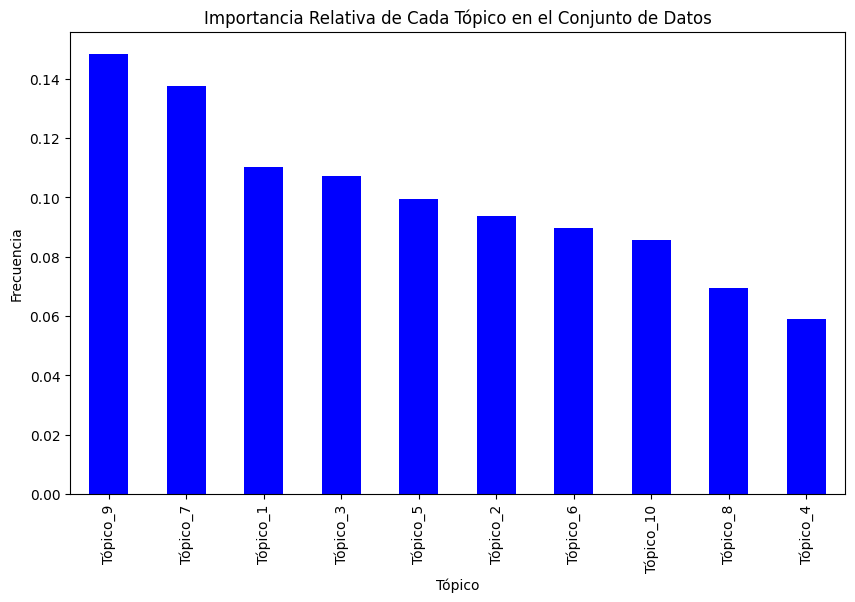

In [ ]:
# Graficar la importancia relativa de cada tópico
fig, ax = plt.subplots(figsize=(10, 6))
sorted_topics.plot(kind='bar', ax=ax, color='blue')
ax.set_xlabel('Tópico')
ax.set_ylabel('Frecuencia')
ax.set_title('Importancia Relativa de Cada Tópico en el Conjunto de Datos')
plt.show()

/databricks/python/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/databricks/python/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


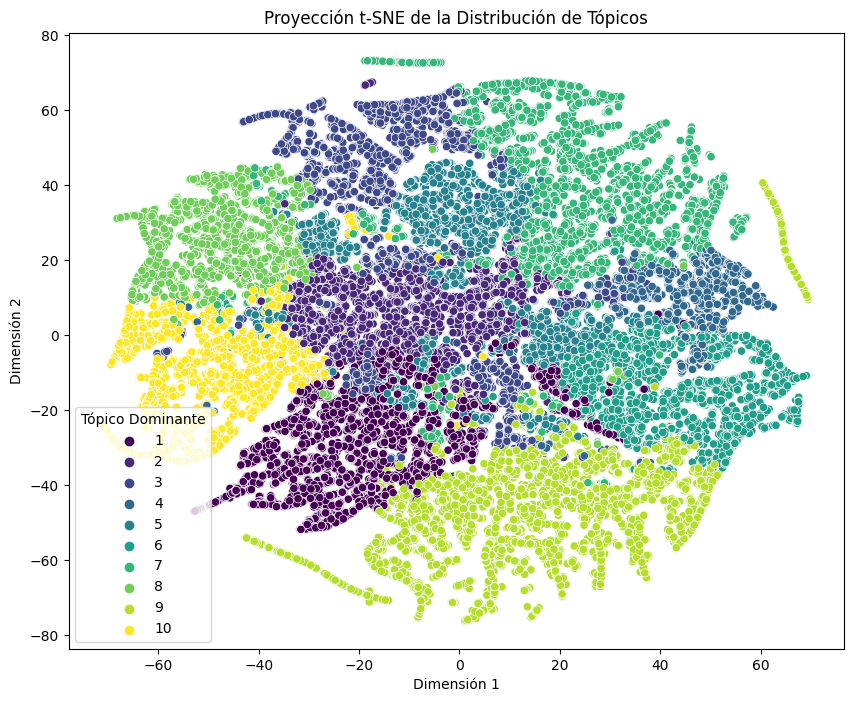

In [ ]:
# Obtener la distribución de tópicos para cada documento
topic_distribution_array = np.array(transformed.select("topicDistribution").collect())

# Aplicar t-SNE para reducir la dimensionalidad
tsne_model = TSNE(n_components=2, random_state=123)
tsne_representation = tsne_model.fit_transform(topic_distribution_array[:, 0, :])

# Crear un DataFrame para facilitar la visualización
df_tsne = pd.DataFrame(tsne_representation, columns=['Dimensión 1', 'Dimensión 2'])

# Agregar información sobre los tópicos
df_tsne['Tópico Dominante'] = np.argmax(topic_distribution_array[:, 0, :], axis=1) + 1

# Graficar el resultado
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dimensión 1', y='Dimensión 2', hue='Tópico Dominante', data=df_tsne, palette='viridis', legend='full')
plt.title('Proyección t-SNE de la Distribución de Tópicos')
plt.show()

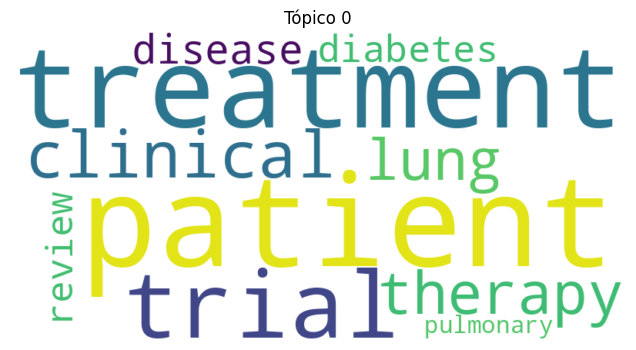

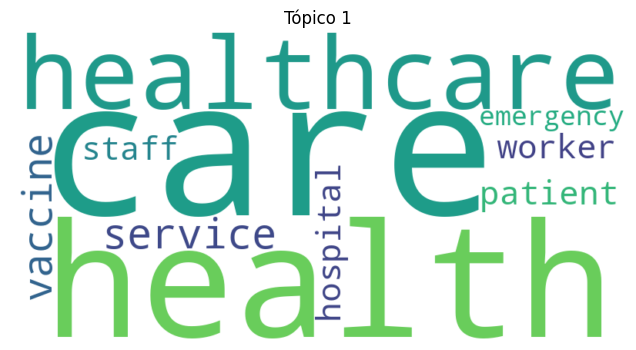

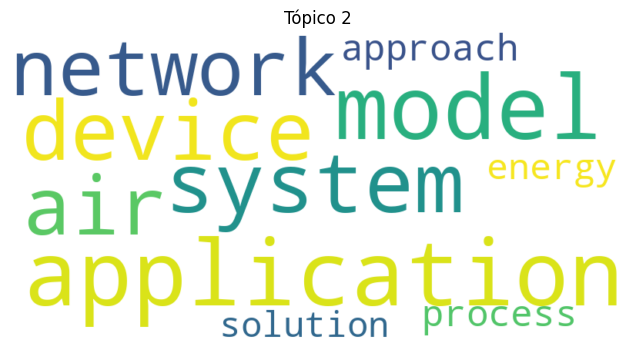

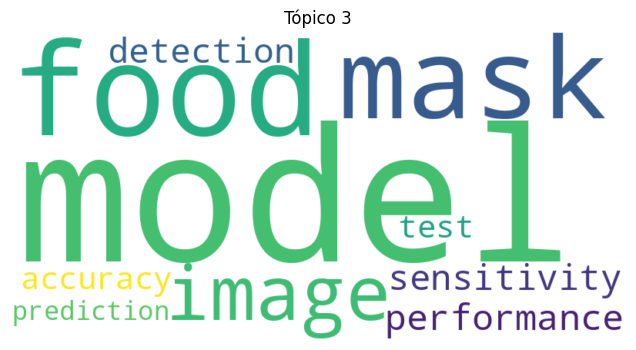

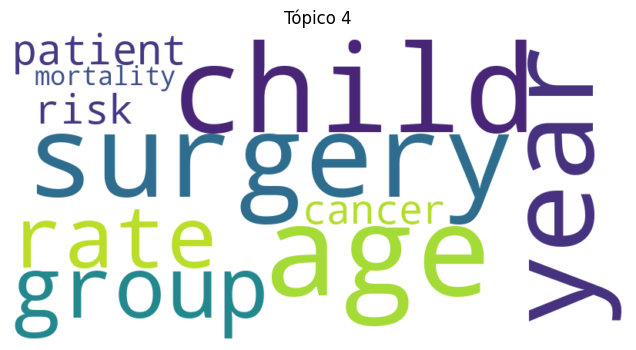

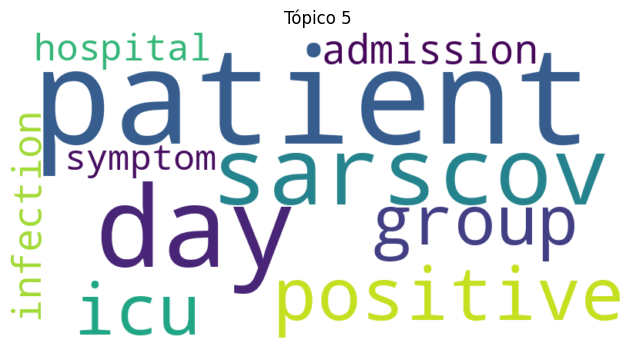

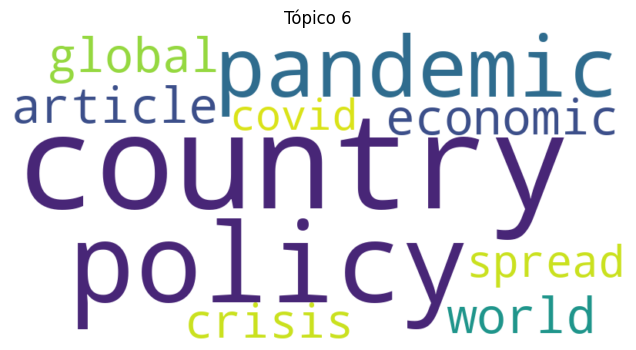

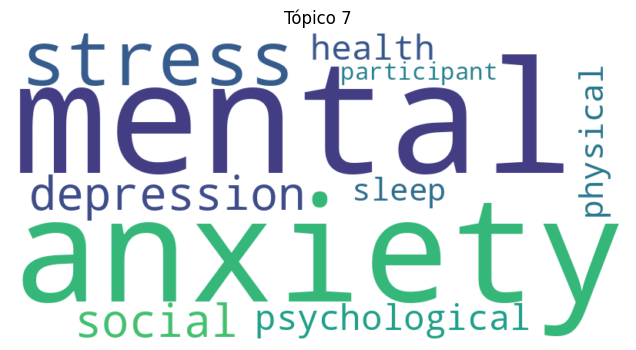

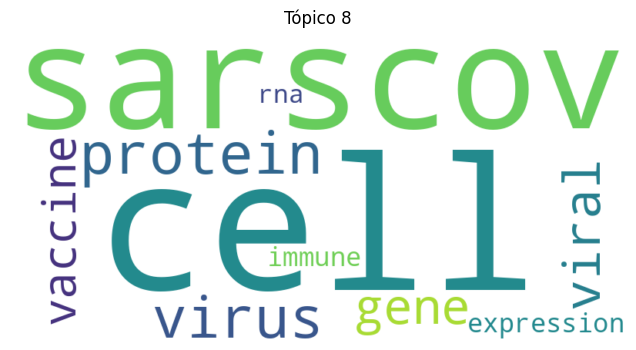

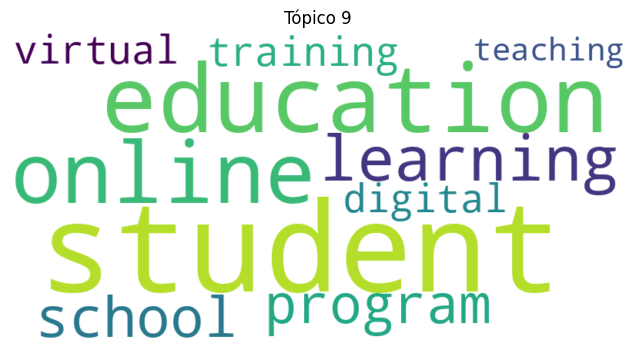

In [ ]:
# Obtener el vocabulario del CountVectorizer
vocabulary = model.vocabulary
vocabulary_dict = {i: term for i, term in enumerate(vocabulary)}

# Crear una función definida por el usuario (UDF) para mapear los índices de palabras a palabras reales
@udf(returnType=ArrayType(StringType()))
def map_indices_to_words(words):
    return [vocabulary_dict[int(index)] for index in words]

# Aplicar el UDF a las columnas de términos e índices de peso de tu modelo LDA
result_with_words = lda_model.describeTopics(maxTermsPerTopic=10).withColumn('words', map_indices_to_words('termIndices'))

# Recolectar los datos en el entorno local
topics_data = result_with_words.select('topic', 'words', 'termWeights').collect()

# Procesar cada tópico para generar la nube de palabras
for topic in topics_data:
    topic_id = topic['topic']
    word_freq = {word: float(prob) for word, prob in zip(topic['words'], topic['termWeights'])}

    # Generar la nube de palabras para el tópico
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    # Mostrar la nube de palabras
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Tópico {topic_id}')
    plt.show()